In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import ltspice
import subprocess
import pickle

In [22]:
# loading parameters
# Read the variables from the file
with open("Model\\parameters.pkl", "rb") as file:
    data = pickle.load(file)

# Access variables from the dictionary
n = data["n"]
m = data["m"]
I = data["I"]
RF_finger = data["RF_finger"]
RB_finger = data["RB_finger"]
RF_busbar = data["RF_busbar"]
RB_busbar = data["RB_busbar"]
Rshunt = data["Rshunt"]
Rseries = data["Rseries"]
Rpogo = data["RPogo_pin"]
Probe_pos = data["Probe_pos"]
Probe_neg = data["Probe_neg"]

In [23]:
#make a log file for this simulation set (change this file name for each directory)
folder_name = "sim1"
file_path = "Model\\sim1\\"
net_name = "solar_cell"

creating the top, finite elements and bottom grid

In [24]:
def netlist_solar_cell_fin_ele(Rsh, Rsr, I, indx, indy):
    netlist =f"""
I{indx}_{indy} T{indx}_{indy} N{indx}_{indy} {I}
D{indx}_{indy} N{indx}_{indy} T{indx}_{indy} D
Rshunt{indx}_{indy} N{indx}_{indy} T{indx}_{indy} {Rsh}
Rseries{indx}_{indy} B{indx}_{indy} N{indx}_{indy} {Rsr}
"""

    return netlist

def netlist_solar_cell_top_ele(R_fingers, R_bb, n, m):
    netlist = ""
    # Rows - Fingers
    # for j in range(0, m+1):  # Loop through rows of fingers
    #     for i in range(0, n):  # Loop through columns of fingers
    #         line = f"RF_f{i}_{j} T{i}_{j} T{i+1}_{j} {R_fingers[j][i]}\n"
    #         netlist += line  # Add to the netlist
    for i in range(0,m+2):
        for j in range(0,n+2):
            if(i>=1 and i<=m):
                if(j<=n):
                   line = f"RF_f{i-1}_{j} T{i}_{j} T{i}_{j+1} {R_fingers[i-1][j]}\n"
                   netlist += line

    # Rows - Busbars
    # for i in range(0, n+1):  # Loop through columns of busbars
    #     for j in range(0, m):  # Loop through rows of busbars
    #         line = f"RF_b{i}_{j} T{i}_{j} T{i}_{j+1} {R_bb[i][j]}\n"
    #         netlist += line  # Add to the netlist
    for j in range(0,n+2):
        for i in range(0,m+2):
            if(j>=1 and j<=n):
                if(i<=m):
                   line = f"RF_b{i}_{j-1} T{i}_{j} T{i+1}_{j} {R_bb[i][j-1]}\n"
                   netlist += line
    return netlist

def netlist_solar_cell_bottom_ele(R_fingers, R_bb, n, m):
    netlist = ""
    # Rows - Fingers
    # for j in range(0, m):  # Loop through rows of fingers
    #     for i in range(0, n):  # Loop through columns of fingers
    #         line = f"RB_f{i}_{j} B{i}_{j} B{i+1}_{j} {R_fingers[j][i]}\n"
    #         netlist += line  # Add to the netlist
    for i in range(0,m+2):
        for j in range(0,n+2):
            if(i>=1 and i<=m):
                if(j<=n):
                   line = f"RB_f{i-1}_{j} B{i}_{j} B{i}_{j+1} {R_fingers[i-1][j]}\n"
                   netlist += line    
    # Rows - Busbars
    # for i in range(0, n):  # Loop through columns of busbars
    #     for j in range(0, m):  # Loop through rows of busbars
    #         line = f"RB_b{i}_{j} B{i}_{j} B{i}_{j+1} {R_bb[i][j]}\n"
    #         netlist += line  # Add to the netlist
    for j in range(0,n+2):
        for i in range(0,m+2):
            if(j>=1 and j<=n):
                if(i<=m):
                   line = f"RB_b{i}_{j-1} B{i}_{j} B{i+1}_{j} {R_bb[i][j-1]}\n"
                   netlist += line
    return netlist

def netlist_V_source():
    netlist = f"V1 Vpos 0 DC 0\n"
    return netlist

def netlist_simtype():
    netlist = ".dc V1 0 0.8 0.01\n"
    return netlist

In [25]:
def solar_cell_netlist():

    # Initialize the netlist with the header
    netlist = """*C:\\Users\\ASUS\\Desktop\\Semesters\\Sem 8\\BTP\\Simulation\\FEM_Mk0\\"""
    netlist += file_path
    netlist += net_name + '.asc\n'
    
    # top resistance grid
    # nodes from T00 to Tnn
    netlist += netlist_solar_cell_top_ele(RF_finger, RF_busbar, n, m)

    # finite element
    # for i in range(0,n):
    #     for j in range(0,m):
    #         netlist += netlist_solar_cell_fin_ele(Rshunt[i][j], Rseries[i][j], I, i, j)
    for i in range(1,m+1):
        for j in range(1,n+1):
            netlist += netlist_solar_cell_fin_ele(Rshunt[i-1][j-1], Rseries[i-1][j-1], I, i, j)
    
    # bottom resistance grid
    # nodes from B00 to Bnn
    netlist += netlist_solar_cell_bottom_ele(RB_finger, RB_busbar, n, m)

    # adding the voltage source
    netlist += netlist_V_source()

    for (x,y) in Probe_pos:
        # netlist = netlist.replace(f" B{x}_{y}", " Vpos")
        netlist += f"RpogoB{x}_{y} B{x}_{y} Vpos {Rpogo}\n"
    
    for (x,y) in Probe_neg:
        # netlist = netlist.replace(f" T{x}_{y}", " 0")
         netlist += f"RpogoT{x}_{y} T{x}_{y} 0 {Rpogo}\n"

    # adding the simulation type
    netlist += netlist_simtype()

    # Add the footer
    netlist += """.model D D
.lib C:\\Users\\ASUS\\AppData\\Local\\LTspice\\lib\\cmp\\standard.dio
.backanno
.end"""

    return netlist


output_file = file_path + net_name +'.net'
with open(output_file, 'w') as file:
    file.write(solar_cell_netlist())

now i have the netlist ready lets try simulating it!

In [26]:
# Path to LTSpice executable
ltspice_exe = 'C:\\Program Files\\ADI\\LTspice\\LTspice.exe'

def RunLTsimulation(netlist_file):
    # Run LTSpice simulation
    subprocess.run([ltspice_exe, '-b', netlist_file], check=True)

# Path to the netlist file
netlist_file = output_file 

#running simulation
RunLTsimulation(netlist_file)

# Extract data
# Load the LTSpice data
lt = ltspice.Ltspice(file_path + net_name +'.raw')
lt.parse()

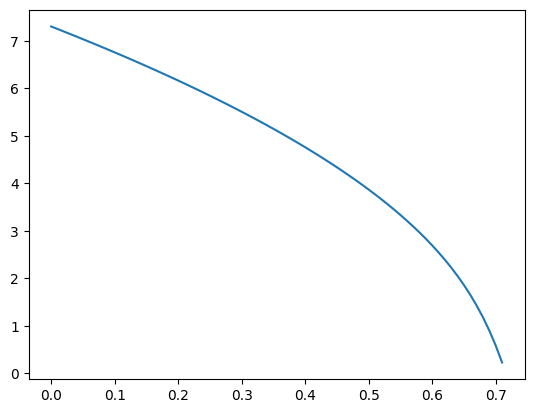

In [27]:
I = lt.get_data("I(V1)")
V = lt.get_data("v1")
#find the point where I becomes zero and stop ploting there
zero_crossing_index = np.argmax(I <= 0)  # First index where I <= 0

# Slice the data up to the zero-crossing point
V_trimmed = V[:zero_crossing_index]
I_trimmed = I[:zero_crossing_index]

plt.plot(V_trimmed,I_trimmed)

In [28]:
# Voltage distribution on each finite element
VB_grid = []
VF_grid = []
I_grid = []

for i in range(1, m+1):
    for j in range(1, n+1):
        VF_grid.append(lt.get_data(f"V(t{i}_{j})"))
        VB_grid.append(lt.get_data(f"V(b{i}_{j})"))
        I_grid.append(lt.get_data(f"I(Rseries{i}_{j})"))

sz = len(I_grid[0])
I_grid = np.array(I_grid).reshape(m, n, sz)
VF_grid = np.array(VF_grid).reshape(m, n, sz)
VB_grid = np.array(VB_grid).reshape(m, n, sz)

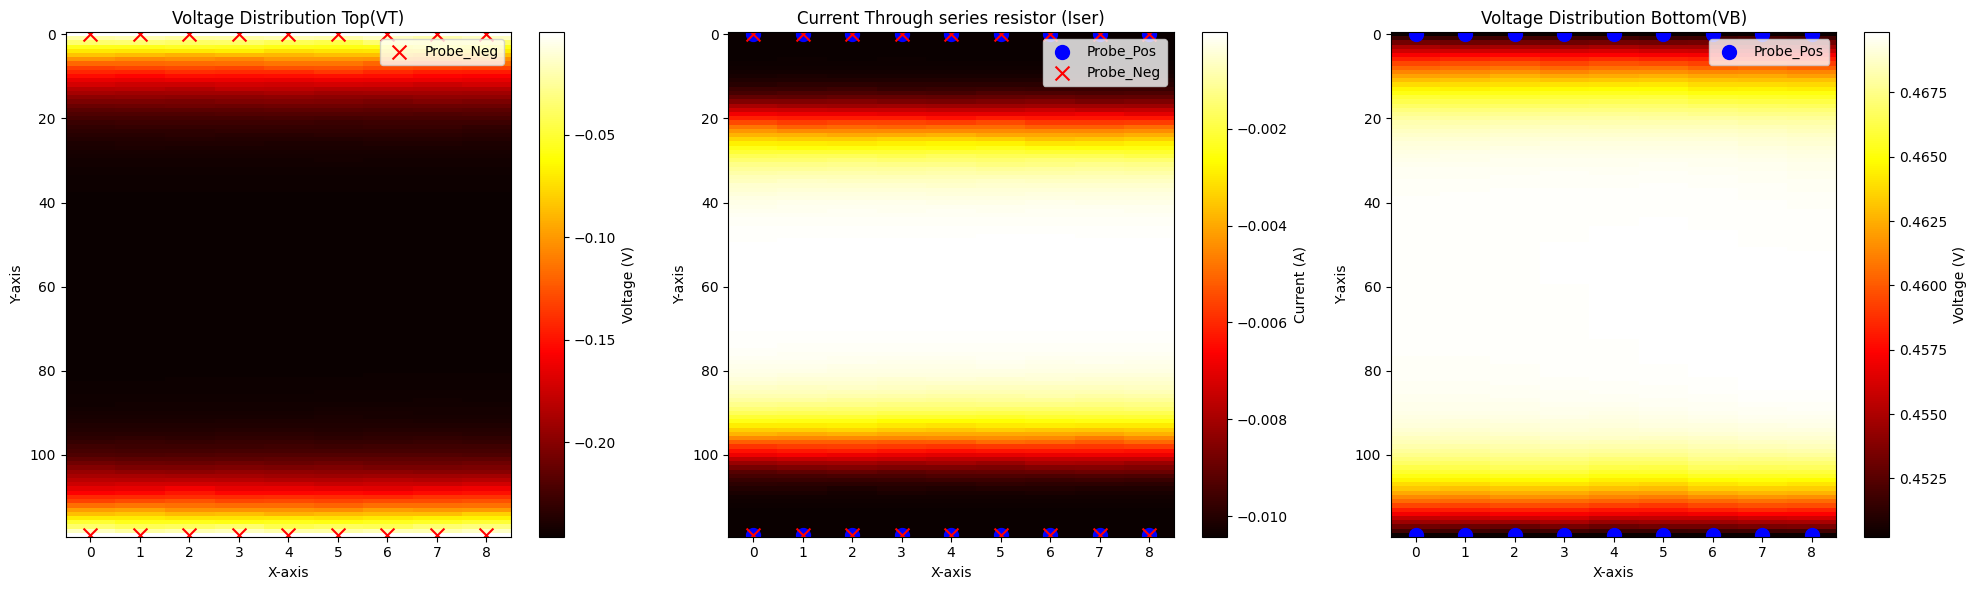

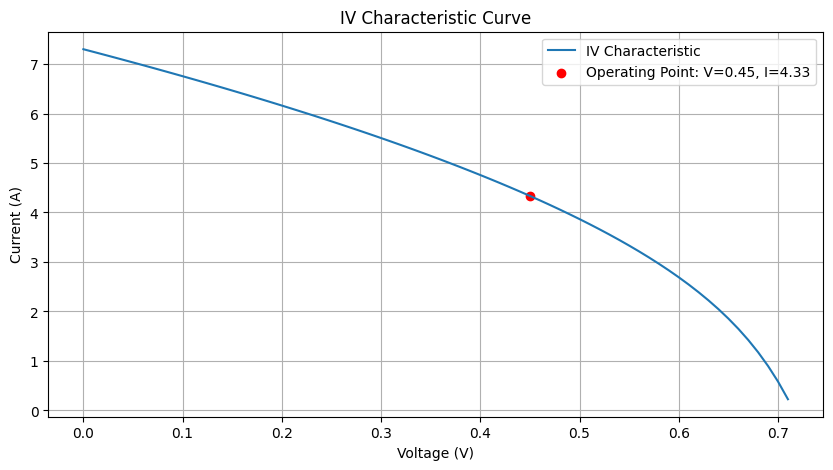

In [29]:
Probe_pos1 = [(x-1, y-1) for x, y in Probe_pos]
Probe_neg1 = [(x-1, y-1) for x, y in Probe_neg]

# Extract x, y positions for probes
Probe_pos_x, Probe_pos_y = zip(*Probe_pos1)
Probe_neg_x, Probe_neg_y = zip(*Probe_neg1)

# Probe_pos_x = Probe_pos_x - 1
# Probe_pos_y = Probe_pos_y - 1
# Probe_neg_x = Probe_neg_x - 1
# Probe_neg_y = Probe_neg_y - 1

# Choose the slice index to visualize
slice_index = 45

# Calculate operating point (example: using the mean values at the slice index)
V_op = np.mean(V[slice_index])
I_op = np.mean(I[slice_index])


# Display the images
plt.figure(figsize=[20, 6])

# Forward Voltage (VF) plane
plt.subplot(1, 3, 1)
plt.scatter(Probe_neg_y, Probe_neg_x, color='red', label='Probe_Neg', s=100, marker='x')  # Negative probesplt.legend()
plt.imshow(VF_grid[:, :, slice_index], aspect='auto', cmap='hot')
plt.colorbar(label='Voltage (V)')
plt.title('Voltage Distribution Top(VT)')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# Current (I) plane
plt.subplot(1, 3, 2)
plt.scatter(Probe_pos_y, Probe_pos_x, color='blue', label='Probe_Pos', s=100, marker='o')  # Positive probes
plt.scatter(Probe_neg_y, Probe_neg_x, color='red', label='Probe_Neg', s=100, marker='x')  # Negative probes
plt.imshow(I_grid[:, :, slice_index], aspect='auto', cmap='hot')
plt.colorbar(label='Current (A)')
plt.title('Current Through series resistor (Iser)')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# Back Voltage (VB) plane
plt.subplot(1, 3, 3)
plt.scatter(Probe_pos_y, Probe_pos_x, color='blue', label='Probe_Pos', s=100, marker='o')  # Positive probes
plt.imshow(VB_grid[:, :, slice_index], aspect='auto', cmap='hot')
plt.colorbar(label='Voltage (V)')
plt.title('Voltage Distribution Bottom(VB)')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.savefig("fin_sim_fr.pdf")
plt.tight_layout()
plt.show()

# Plot IV characteristic curve
plt.figure(figsize=[10, 5])
plt.plot(V_trimmed,I_trimmed, label='IV Characteristic')
plt.scatter(V_op, I_op, color='red', label=f'Operating Point: V={V_op:.2f}, I={I_op:.2f}')
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')
plt.title('IV Characteristic Curve')
plt.legend()
plt.grid(True)
plt.savefig("fin_sim_IV.pdf")
plt.show()

GIF saved as 'voltage_current_back_voltage.gif'


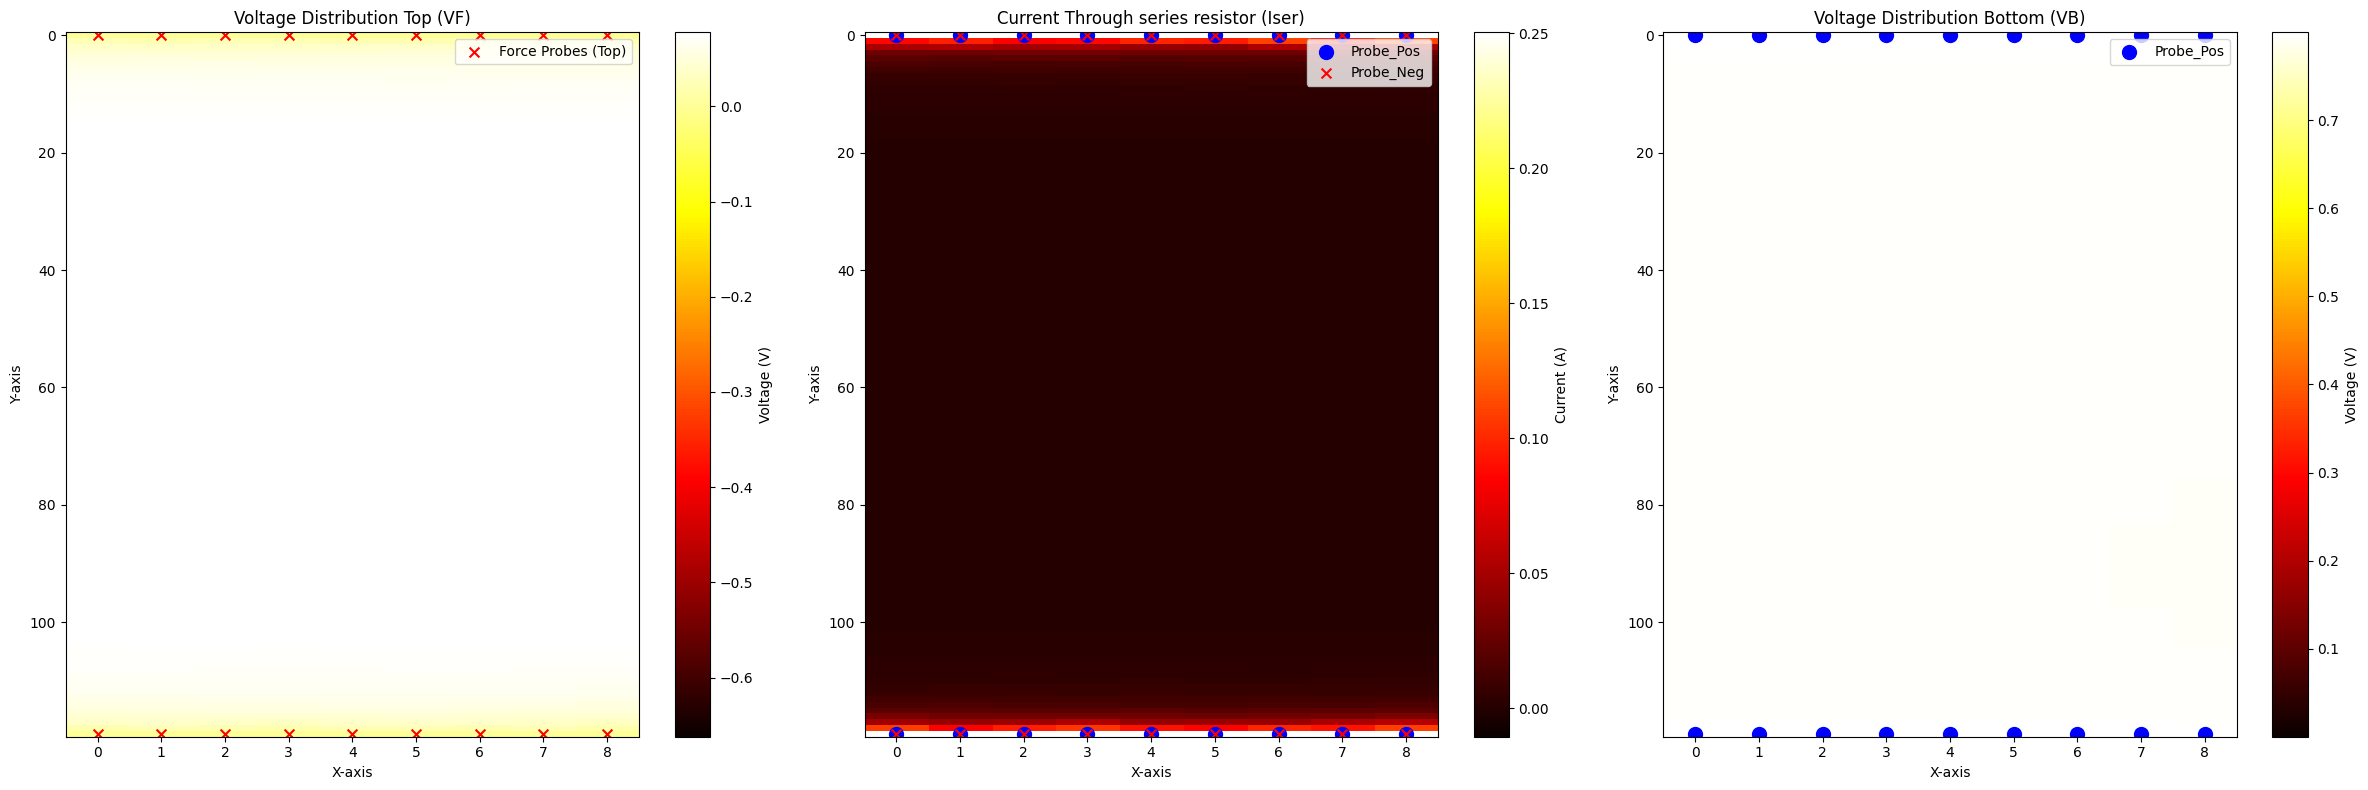

In [31]:
# Define color scale range for the selected plots (VF, I, and VB)
vmin_vf, vmax_vf = VF_grid.min(), VF_grid.max()  # Range for VF
vmin_i, vmax_i = I_grid.min(), I_grid.max()     # Range for I
vmin_vb, vmax_vb = VB_grid.min(), VB_grid.max() # Range for VB

# Initialize the figure for three subplots
fig, ax = plt.subplots(1, 3, figsize=(24, 8))

# Create the initial plots for each subplot (same as the code you provided)

# Voltage (VF) plane
ax[0].scatter(Probe_neg_y, Probe_neg_x, color='red', label='Force Probes (Top)', s=50, marker='x')
im_vf = ax[0].imshow(VF_grid[:, :, 0], aspect="auto", cmap="hot", vmin=vmin_vf, vmax=vmax_vf)
fig.colorbar(im_vf, ax=ax[0], label="Voltage (V)")
ax[0].set_title("Voltage Distribution Top (VF)")
ax[0].set_xlabel("X-axis")
ax[0].set_ylabel("Y-axis")
ax[0].legend()

# Current (I) plane
ax[1].scatter(Probe_pos_y, Probe_pos_x, color='blue', label='Probe_Pos', s=100, marker='o')
ax[1].scatter(Probe_neg_y, Probe_neg_x, color='red', label='Probe_Neg', s=50, marker='x')
im_i = ax[1].imshow(I_grid[:, :, 0], aspect="auto", cmap="hot", vmin=vmin_i, vmax=vmax_i)
fig.colorbar(im_i, ax=ax[1], label="Current (A)")
ax[1].set_title("Current Through series resistor (Iser)")
ax[1].set_xlabel("X-axis")
ax[1].set_ylabel("Y-axis")
ax[1].legend()

# Back Voltage (VB) plane
ax[2].scatter(Probe_pos_y, Probe_pos_x, color='blue', label='Probe_Pos', s=100, marker='o')
im_vb = ax[2].imshow(VB_grid[:, :, 0], aspect="auto", cmap="hot", vmin=vmin_vb, vmax=vmax_vb)
fig.colorbar(im_vb, ax=ax[2], label="Voltage (V)")
ax[2].set_title("Voltage Distribution Bottom (VB)")
ax[2].set_xlabel("X-axis")
ax[2].set_ylabel("Y-axis")
ax[2].legend()

plt.tight_layout()

# Animation update function
def update(slice_index):
    # Update each subplot with the current slice index
    im_vf.set_array(VF_grid[:, :, slice_index])  # Update VF grid for the current slice index
    im_i.set_array(I_grid[:, :, slice_index])    # Update I grid for the current slice index
    im_vb.set_array(VB_grid[:, :, slice_index])  # Update VB grid for the current slice index
    return [im_vf, im_i, im_vb]  # Return all updated images

# Create the animation
anim = FuncAnimation(fig, update, frames=range(0, 81), interval=200, blit=True)

# Save the animation as a GIF
gif_writer = PillowWriter(fps=5)  # Adjust FPS for speed
anim.save("voltage_current_back_voltage.gif", writer=gif_writer)

print("GIF saved as 'voltage_current_back_voltage.gif'")